In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [86]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [87]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index):
    λ_1 = 0.04
    λ_2 = 0.06
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2))]
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [88]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [89]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 59.  50.  68.]
 [ 50. 100.   0.]
 [ 50.   0. 100.]
 [ 55.  56.  54.]]


In [90]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 57.  18.  96.]
 [ 50.   0. 100.]
 [ 50.   6.  94.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]
 [ 50.   0. 100.]]


In [91]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_30_3/feat_left_A07T_30.txt","feat_2a_250Hz_30_3/feat_right_A07T_30.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 44.  36.  52.]
 [ 50.   0. 100.]
 [ 53.  52.  54.]
 [ 51.  22.  80.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [8]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[ 50.33333333  18.          82.66666667]
 [ 50.           0.         100.        ]
 [ 54.          36.          72.        ]
 [ 50.33333333  74.          26.66666667]
 [ 50.          66.66666667  33.33333333]
 [ 51.66666667  52.          51.33333333]]


In [9]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 51.  74.  28.]
 [ 50.   0. 100.]
 [ 57.  48.  66.]
 [ 54.   8. 100.]
 [ 50.  20.  80.]
 [ 48.  96.   0.]]


In [10]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 50.   0. 100.]
 [ 48.  88.   8.]
 [ 57.  22.  92.]
 [ 50. 100.   0.]
 [ 50.   0. 100.]
 [ 55.  46.  64.]]


In [11]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 50.   0. 100.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]
 [ 52.  24.  80.]
 [ 56.  28.  84.]
 [ 59.  42.  76.]]


In [12]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[50.33333333 24.66666667 76.        ]
 [49.33333333 62.66666667 36.        ]
 [54.66666667 56.66666667 52.66666667]
 [52.         44.         60.        ]
 [52.         16.         88.        ]
 [54.         61.33333333 46.66666667]]


In [13]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

51.055555555555564 52.055555555555564


[[50.33333333 49.33333333 54.66666667 52.         52.         54.        ]
 [50.33333333 50.         54.         50.33333333 50.         51.66666667]]


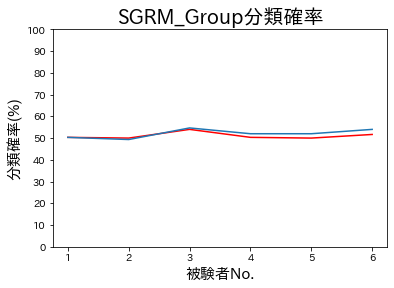

In [14]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3.pdf")
plt.show()

In [15]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


[[51. 92. 10.]
 [50. 98.  2.]
 [54. 76. 32.]]


In [16]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

[[49. 92.  6.]
 [52. 60. 44.]
 [51. 30. 72.]]


In [17]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 51.  90.  12.]
 [ 50.   0. 100.]
 [ 53.  86.  20.]]


In [18]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
print(p_average_1000Hz)

[[50.33333333 91.33333333  9.33333333]
 [50.66666667 52.66666667 48.66666667]
 [52.66666667 64.         41.33333333]]


In [19]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 49.   0.  98.]
 [ 50.   0. 100.]]


In [20]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 51.  10.  92.]
 [ 50. 100.   0.]
 [ 50.   0. 100.]]


In [21]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 50.   0. 100.]
 [ 48.   6.  90.]
 [ 51. 100.   2.]]


In [22]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
print(p_average_100Hz)

[[50.33333333  3.33333333 97.33333333]
 [49.         35.33333333 62.66666667]
 [50.33333333 33.33333333 67.33333333]]


In [23]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

51.22222222222222 49.88888888888889


[[50.33333333 49.         50.33333333]
 [50.33333333 50.66666667 52.66666667]]


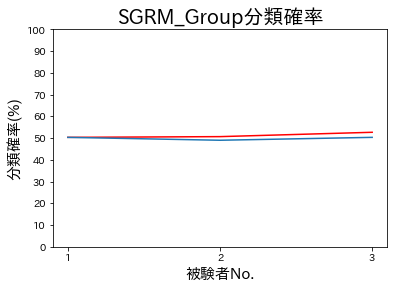

In [24]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3.pdf")
plt.show()

In [25]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50.   2.  98.]
 [ 50.   0. 100.]
 [ 59.  50.  68.]
 [ 56.  48.  64.]
 [ 53.  70.  36.]
 [ 49.  90.   8.]]


In [26]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


[[ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 52.  98.   6.]
 [ 52. 100.   4.]
 [ 50. 100.   0.]
 [ 52.   4. 100.]]


In [27]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 50.  50.  50.]
 [ 50.   0. 100.]
 [ 57.  88.  26.]
 [ 47.   0.  94.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [28]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[ 50.          17.33333333  82.66666667]
 [ 50.           0.         100.        ]
 [ 56.          78.66666667  33.33333333]
 [ 51.66666667  49.33333333  54.        ]
 [ 51.          90.          12.        ]
 [ 50.33333333  64.66666667  36.        ]]


In [29]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 49.  52.  46.]
 [ 50.   0. 100.]
 [ 53.  32.  74.]
 [ 50.   0. 100.]
 [ 50. 100.   0.]
 [ 58.  34.  82.]]


In [30]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 50.   0. 100.]
 [ 50.  98.   2.]
 [ 47.  94.   0.]
 [ 51.   2. 100.]
 [ 50. 100.   0.]
 [ 53.   8.  98.]]


In [31]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 35.  48.  22.]
 [ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 54.  10.  98.]
 [ 44.  50.  38.]
 [ 64.  68.  60.]]


In [32]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[44.66666667 33.33333333 56.        ]
 [50.         32.66666667 67.33333333]
 [50.         42.         58.        ]
 [51.66666667  4.         99.33333333]
 [48.         83.33333333 12.66666667]
 [58.33333333 36.66666667 80.        ]]


In [33]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

51.49999999999999 50.444444444444436


[[44.66666667 50.         50.         51.66666667 48.         58.33333333]
 [50.         50.         56.         51.66666667 51.         50.33333333]]


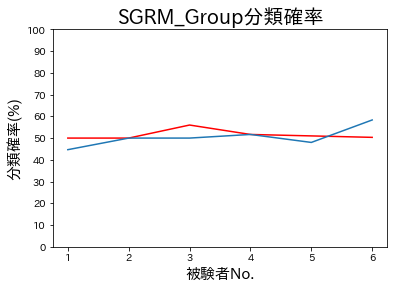

In [34]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3_down.pdf")
plt.show()

In [35]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[49.  0. 98.]
 [50. 62. 38.]
 [52. 54. 50.]]


In [36]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


[[ 50.   0. 100.]
 [ 50.  58.  42.]
 [ 49.  12.  86.]]


In [37]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 52.  26.  78.]
 [ 50.   0. 100.]
 [ 49.  20.  78.]]


In [38]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
print(p_average_1000Hz)

[[50.33333333  8.66666667 92.        ]
 [50.         40.         60.        ]
 [50.         28.66666667 71.33333333]]


In [39]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 50.  96.   4.]
 [ 47.   2.  92.]]


In [40]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 52.  42.  62.]
 [ 50. 100.   0.]
 [ 46.  12.  80.]]


In [41]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 50.   0. 100.]
 [ 47.   4.  90.]
 [ 51. 100.   2.]]


In [42]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
print(p_average_100Hz)

[[50.66666667 14.         87.33333333]
 [49.         66.66666667 31.33333333]
 [48.         38.         58.        ]]


In [43]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

50.111111111111114 49.22222222222222


[[50.66666667 49.         48.        ]
 [50.33333333 50.         50.        ]]


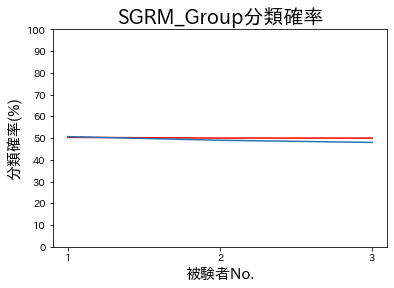

In [44]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3_10.pdf")
plt.show()

In [64]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 50.   0. 100.]
 [ 50.  96.   4.]
 [ 50.   0. 100.]]


In [ ]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

In [68]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 50. 100.   0.]
 [ 49.  94.   4.]
 [ 52.   4. 100.]]


In [69]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[ 50.          33.33333333  66.66666667]
 [ 48.66666667  92.66666667   4.66666667]
 [ 50.66666667   1.33333333 100.        ]]


In [70]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 53. 100.   6.]
 [ 52. 100.   4.]
 [ 58.  46.  70.]]


In [71]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 57.  94.  20.]
 [ 52. 100.   4.]
 [ 50.   0. 100.]]


In [72]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)
        

[[ 50. 100.   0.]
 [ 51.  98.   4.]
 [ 50.   2.  98.]]


In [73]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[53.33333333 98.          8.66666667]
 [51.66666667 99.33333333  4.        ]
 [52.66666667 16.         89.33333333]]


In [74]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

49.77777777777777 52.55555555555555


In [76]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 48.  84.  12.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [77]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

[[57. 56. 58.]
 [49.  4. 94.]
 [45. 76. 14.]]


In [78]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)

[[ 48.  60.  36.]
 [ 50.   0. 100.]
 [ 50. 100.   0.]]


In [79]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[51.         66.66666667 35.33333333]
 [49.66666667 34.66666667 64.66666667]
 [48.33333333 92.          4.66666667]]


In [80]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

[[ 49.  98.   0.]
 [ 50. 100.   0.]
 [ 50.  12.  88.]]


In [81]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

[[ 53.  98.   8.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [82]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)
        

[[ 49.  24.  74.]
 [ 57.  48.  66.]
 [ 50. 100.   0.]]


In [83]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[50.33333333 73.33333333 27.33333333]
 [52.33333333 82.66666667 22.        ]
 [50.         70.66666667 29.33333333]]


In [84]:
a_20 = 0; a_30 = 0;
for i in range(2):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/2
a_30 = a_30/2
print(a_20,a_30)

50.33333333333333 51.333333333333336
